## Импорт необходимых модулей и определение констант

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
from skimage.io import imread
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator, array_to_img

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import learning_curve
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans


In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
SEED = 21
np.random.seed(SEED)
IMAGE_PATH = "./data/Raw/"
plt.style.use('fivethirtyeight')

## Загрузка набора данных и предварительный анализ

### Функции отрисовки

Отрисовка нескольких изображений по пути файла

In [4]:
def draw_pictures(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    plt.subplots(squeeze=False, figsize=(10, 10), constrained_layout=True)
    plt.grid(False)
    for i in range(n):
        plt.subplot2grid((rows, cols), (i//cols, i % cols)
                         ).imshow(imread(img_df['path'][i]))
        plt.title(img_df['img_label'][i])
    plt.show()

Отрисовка одного изображения с его цветовой гистограммой

In [5]:
def draw_image_with_hist(image):
    fig, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
    axes[0].imshow(array_to_img(image))
    axes[1].hist(image.ravel(), bins = 256, color = 'orange')
    axes[1].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    axes[1].hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    axes[1].hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    axes[1].set_xlabel('Интенсивность')
    axes[1].set_ylabel('Количество')
    axes[1].legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
    plt.show()
  

Отрисовка нескольких изображений с их цветовыми гистограммами

In [6]:
def draw_pictures_with_hists(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    fig, axes = plt.subplots(rows*2, cols, figsize=(cols*5,rows*10), constrained_layout=True)
    fig.suptitle('Цветовая гистограмма', fontsize=21)
    row_i =0
    for i in range(n):
        image = imread(img_df['path'][i])
        axes[row_i, i%cols].hist(image.ravel(), bins = 256, color = 'orange', )
        axes[row_i, i%cols].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
        axes[row_i, i%cols].legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
        axes[row_i, i%cols].set_xlabel('Интенсивность')
        axes[row_i, i%cols].set_ylabel('Количество')
        axes[row_i+1, i%cols].imshow(image)
        if (i%cols+1 == cols):
            row_i += 2

        

### Загрузка данных для датасета

Функция выделения признаков из датасета

In [7]:
def img_params(img_path):
    img = imread(img_path) 
    img_class = img_path.replace(IMAGE_PATH, '').split('\\')[0]
    img_color = np.sum(img.reshape(-1, 3)*np.asarray([65536, 256, 1]), axis=1)
    return classes_dict[img_class.lower()], img_class, img_path, img.shape[0], img.shape[1], img.shape[2], img_color.max(), img_color.min(), img_color.mean(), img_color.std(), np.median(img_color)

In [8]:
image_files = []
classes_dict = {}
for k, dir in enumerate(os.listdir(IMAGE_PATH)):
    classes_dict[dir.lower()] = k
    image_files.extend(os.path.join(IMAGE_PATH, dir, file) for file in os.listdir(os.path.join(IMAGE_PATH, dir)) if file.endswith(('.JPG', '.jpg', '.png')))

Пронумерованные классы датасета

In [9]:
for class_title, class_number in classes_dict.items():
    print (f"Класс: \033[1m{class_title}\033[0m - номер {class_number}")

Класс: fork - номер 0
Класс: knife - номер 1
Класс: spoon - номер 2


Создание датасета признаков

In [10]:
images_data = np.array(list(map(img_params, np.asarray(image_files))))
df = pd.DataFrame(columns=['img_class','img_label','path','height', 'width', 'dimension', 'max_rgb', 'min_rgb', 'mean_rgb', 'std_rgb', 'median_rgb'], data=images_data)
df = df.astype({'height': 'int32', 'width': 'int32', 'dimension': 'int32', 'max_rgb': 'float32',
          'min_rgb': 'float32', 'mean_rgb': 'float32', 'std_rgb': 'float32', 'median_rgb': 'float32'})


Состав полей датасета:
- **img_class** - класс, к которому относится изображение
- **img_label** - название класса, к которому относится изображение
- **path** - путь к файлу изображения
- **height** - высота изображения
- **width** - ширина изображения
- **dimension** - количество цветовых каналов изображения
- **max_rgb** - максимальное значение пикселя в изображении
- **min_rgb** - минимальное значение пикселя в изображении
- **mean_rgb** - среднее значение пикселя в изображении
- **std_rgb**  - стандартное отклонение значения пикселя в изображении
- **median_rgb** - медианное значение пикселя в изображении

In [11]:
print(f'Количество фотографий в датасете: {df.shape[0]}')
print('Количество отсутствующих значений в датасете и типы данных по столбцам:\n')
print(df.info())

Количество фотографий в датасете: 550
Количество отсутствующих значений в датасете и типы данных по столбцам:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_class   550 non-null    object 
 1   img_label   550 non-null    object 
 2   path        550 non-null    object 
 3   height      550 non-null    int32  
 4   width       550 non-null    int32  
 5   dimension   550 non-null    int32  
 6   max_rgb     550 non-null    float32
 7   min_rgb     550 non-null    float32
 8   mean_rgb    550 non-null    float32
 9   std_rgb     550 non-null    float32
 10  median_rgb  550 non-null    float32
dtypes: float32(5), int32(3), object(3)
memory usage: 30.2+ KB
None


### Несколько точек данных

In [12]:
print('Первые 5 строчек датасета:')
df.head()

Первые 5 строчек датасета:


,img_class,img_label,path,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
0,0,FORK,./data/Raw/FORK\dinnerforkraw1.JPG,1536,2048,3,16777215.0,333056.0,7491456.50,1019980.375,7642624.0
1,0,FORK,./data/Raw/FORK\dinnerforkraw10.JPG,1536,2048,3,16777215.0,0.0,2927378.25,1440428.250,2631722.0
2,0,FORK,./data/Raw/FORK\dinnerforkraw11.JPG,1536,2048,3,16777215.0,0.0,2951275.50,1494476.875,2632749.0
3,0,FORK,./data/Raw/FORK\dinnerforkraw12.JPG,1536,2048,3,16776952.0,1507329.0,8132682.50,976349.250,8220690.0
4,0,FORK,./data/Raw/FORK\dinnerforkraw13.JPG,1536,2048,3,16777213.0,3021312.0,11575016.00,1106303.500,11643697.0


Первые 5 изображений датасета:


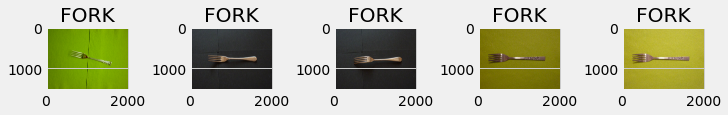

In [13]:
print('Первые 5 изображений датасета:')
draw_pictures(df[:5])

Изображения экземпляров разных классов:


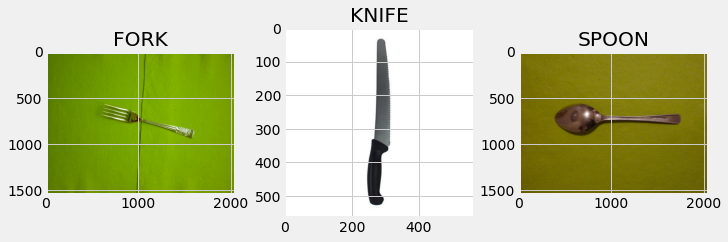

In [14]:
print('Изображения экземпляров разных классов:')
draw_pictures(df.groupby('img_class').min())

## Описательный анализ данных

### Описание численных типов данных

In [15]:
df.describe()

,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
count,550.000000,550.000000,550.0,550.00,550.00,5.500000e+02,5.500000e+02,550.00
mean,1787.801818,2081.161818,3.0,16244850.00,1253941.00,8.277548e+06,1.617340e+06,8347350.00
std,1019.735193,911.039918,0.0,1299180.00,1759103.50,3.331327e+06,7.279934e+05,3593154.25
min,100.000000,150.000000,3.0,8342351.00,0.00,8.575829e+05,1.310755e+05,181094.00
25%,1536.000000,2048.000000,3.0,16755698.25,1287.50,6.634091e+06,1.024465e+06,6599068.25
50%,1536.000000,2048.000000,3.0,16777191.00,458881.50,8.708558e+06,1.454581e+06,8816540.50
75%,1536.000000,2048.000000,3.0,16777215.00,2035909.25,9.910859e+06,2.044419e+06,10000154.50
max,4128.000000,4128.000000,3.0,16777215.00,12358217.00,1.676048e+07,4.511373e+06,16777215.00


#### Визуализация численных данных

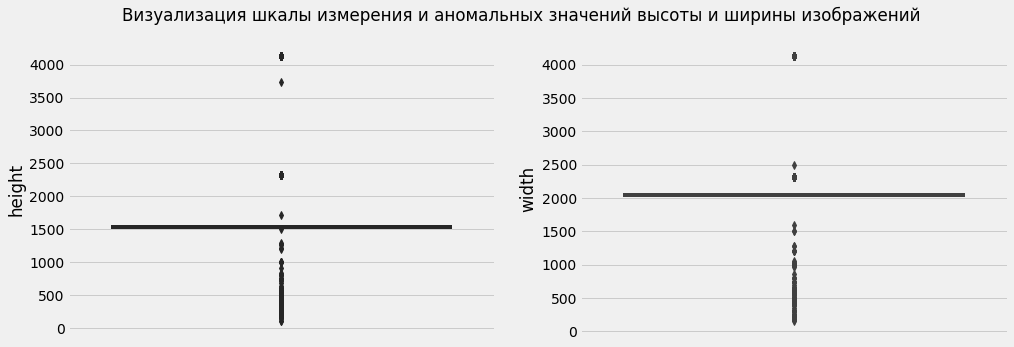

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений')
sns.boxplot(ax=axes[0], y="height", data=df, color='green')
sns.boxplot(ax=axes[1], y="width", data=df)
plt.show()

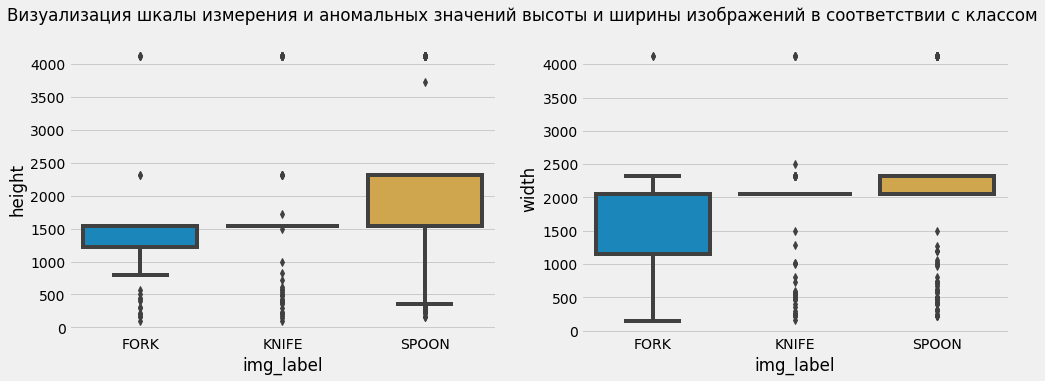

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений в соответствии с классом')
sns.boxplot(ax=axes[0], x="img_label", y="height", data=df)
sns.boxplot(ax=axes[1], x="img_label", y="width", data=df)
plt.show()

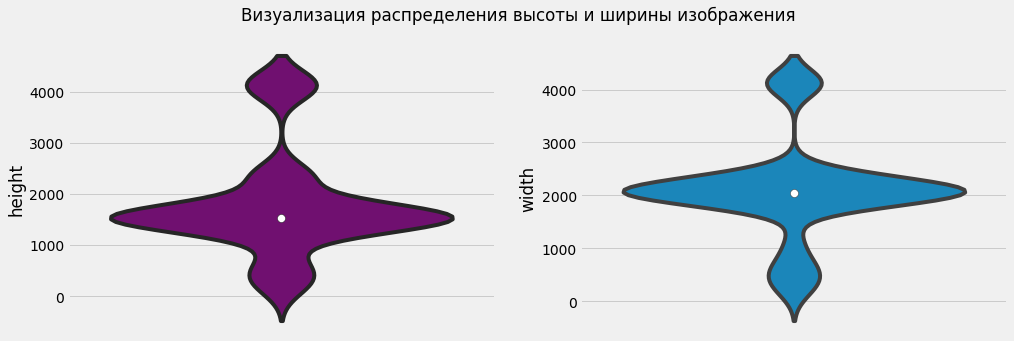

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация распределения высоты и ширины изображения ')
sns.violinplot(ax=axes[0], y = df['height'], color='purple')
sns.violinplot(ax=axes[1], y = df['width'])
plt.show()

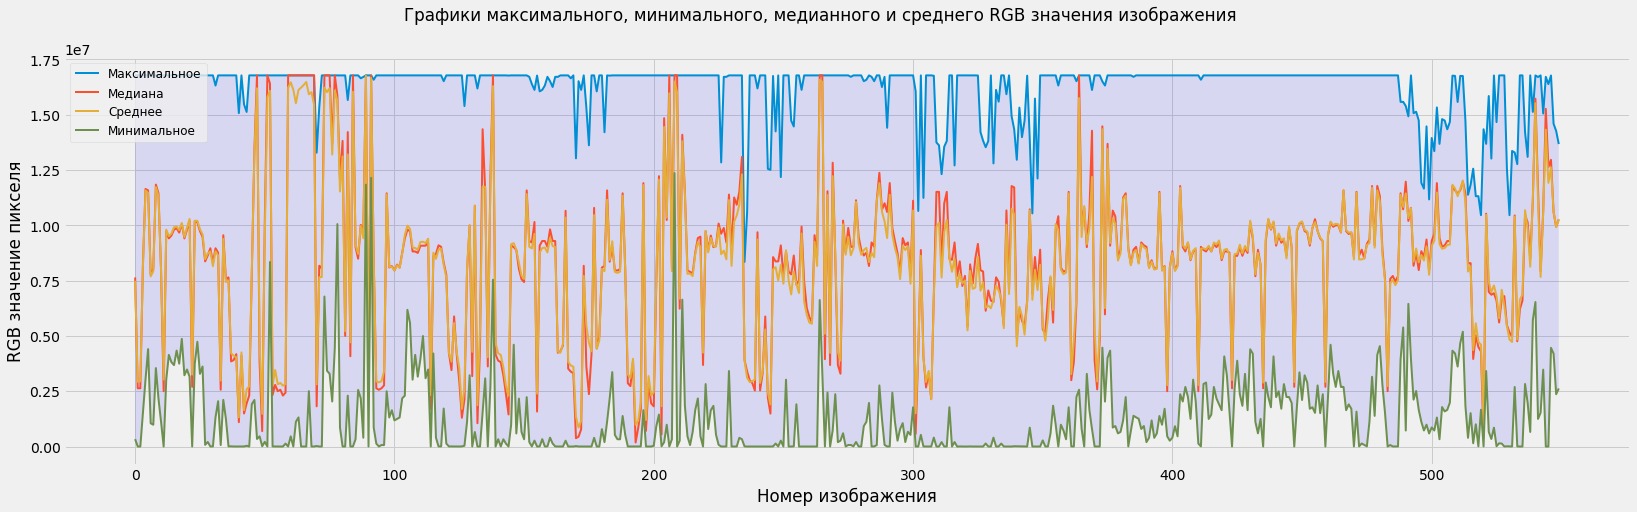

In [219]:
f, ax = plt.subplots(figsize=(25, 7))
f.suptitle('Графики максимального, минимального, медианного и среднего RGB значения изображения')
sns.lineplot(label='Максимальное', data=df['max_rgb'], lw=2)
sns.lineplot(label='Медиана', data=df['median_rgb'], lw=2)
sns.lineplot(label='Среднее', data=df['mean_rgb'], lw=2)
sns.lineplot(label='Минимальное', data=df['min_rgb'], lw=2)
plt.fill_between(df.index, df['min_rgb'], df['max_rgb'], edgecolor='none',facecolor='blue', alpha=0.1)
plt.legend(fontsize=12, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()

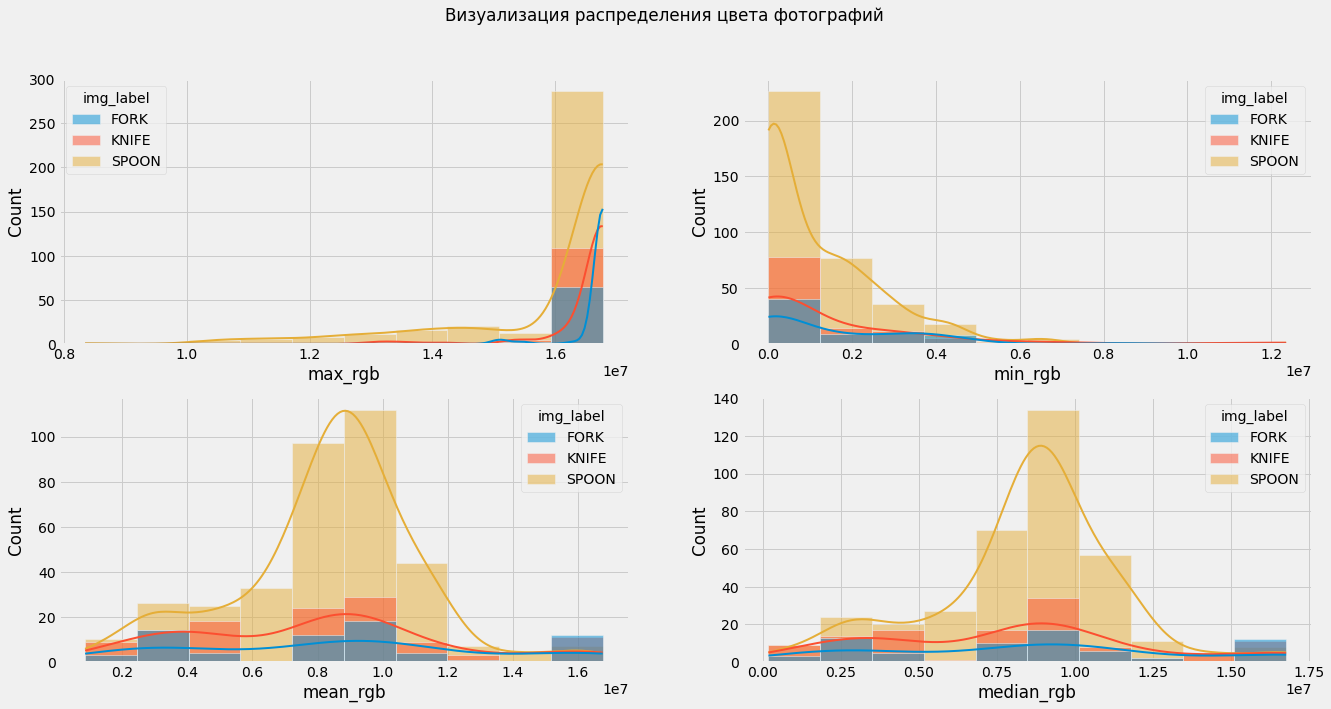

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Визуализация распределения цвета фотографий')
sns.histplot(ax=axes[0,0], data=df, x="max_rgb", hue="img_label", kde=True, bins=10, line_kws=dict(linewidth=2))
sns.histplot(ax=axes[0,1], data=df, x="min_rgb", hue="img_label", kde=True, bins=10, line_kws=dict(linewidth=2))
sns.histplot(ax=axes[1,0], data=df, x="mean_rgb", hue="img_label", kde=True, bins=10, line_kws=dict(linewidth=2))
sns.histplot(ax=axes[1,1], data=df, x="median_rgb", hue="img_label", kde=True, bins=10, line_kws=dict(linewidth=2))
plt.show()

In [201]:
def number_to_color(number):
    return '#'+hex(int(number)).replace('0x', '').rjust(6, '0')

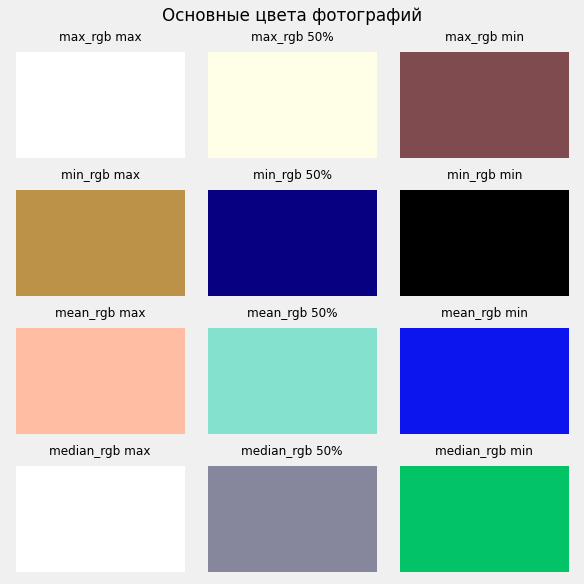

In [205]:
df_decribe = df.describe()
cols = df_decribe.columns[3:].drop('std_rgb')
params = ['max', '50%', 'min']
n = 2
fig, axes = plt.subplots(len(cols), len(params), figsize=(n*4, n*4), constrained_layout=True)
fig.suptitle('Основные цвета фотографий')
for i, label in enumerate(cols):
    for j, param in enumerate(params):
        axes[i, j].fill([0,0,n, n], [0,n,n,0], number_to_color(df_decribe[label][param]))
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{label} {param}", fontsize=12)
plt.show()

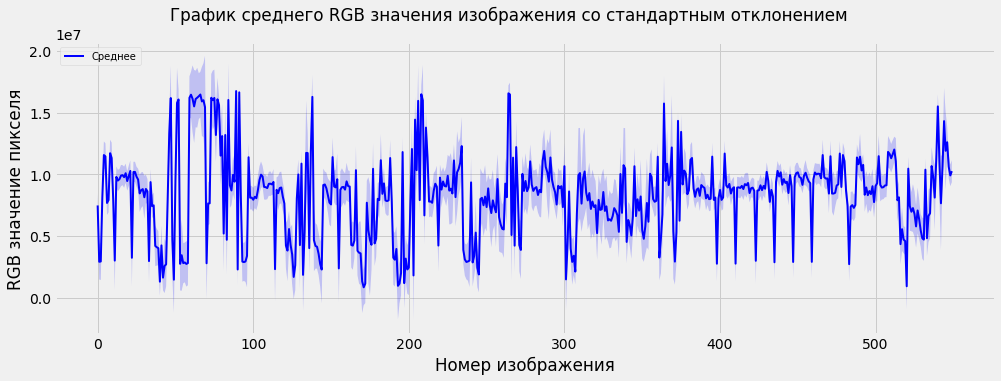

In [225]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('График среднего RGB значения изображения со стандартным отклонением')
sns.lineplot(label='Среднее', data=df['mean_rgb'], color='blue', lw=2)
plt.fill_between(df.index, df['mean_rgb'] - df['std_rgb'], df['mean_rgb'] + df['std_rgb'], edgecolor='none',
                    facecolor='blue', alpha=0.2)
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()


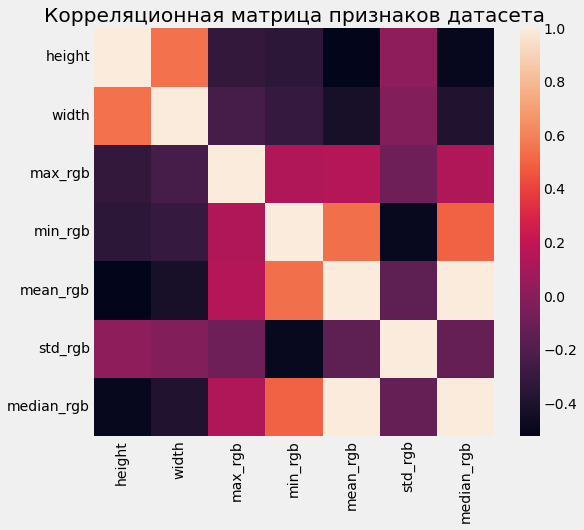

In [47]:
plt.rcParams['figure.figsize'] = (8,7)
plt.title("Корреляционная матрица признаков датасета")
sns.heatmap(df.drop('dimension', axis=1).corr())
plt.show()

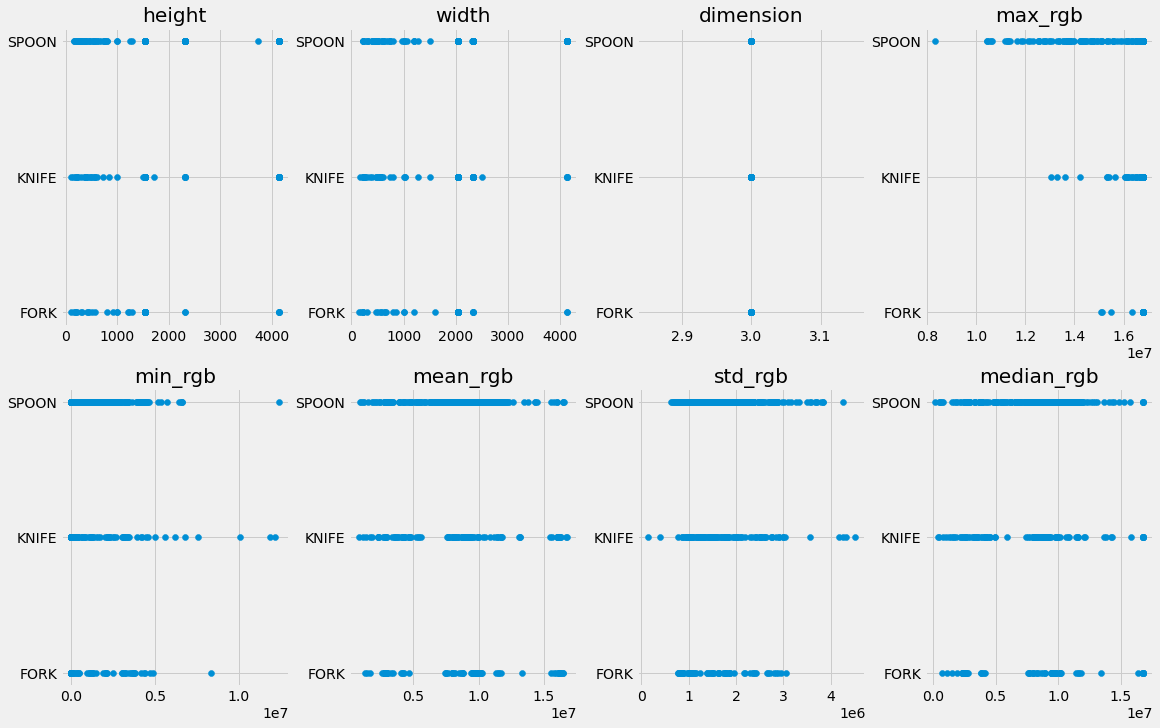

In [48]:
plt.subplots(figsize=(16, 10), constrained_layout=True)
for i, col in enumerate(df.columns[3:]):
    plt.subplot(2, 4, i+1)
    plt.scatter(df[col], df['img_label'])
    plt.title(col)

### Описание категориальных типов данных

In [49]:
df.describe(include = ['O'])

,img_class,img_label,path
count,550,550,550
unique,3,3,550
top,2,SPOON,./data/Raw/FORK\dinnerforkraw1.JPG
freq,365,365,1


Распределение данных внутри датасета

In [50]:
for class_title, class_number in classes_dict.items():
    print (f"Класс номер {class_number} {class_title}: {len(df[df['img_class'] == str(class_number)])} ({len(df[df['img_class'] == str(class_number)])/len(df)*100:.2f}%)")
print (f"Всего: {len(df)}")

Класс номер 0 fork: 68 (12.36%)
Класс номер 1 knife: 117 (21.27%)
Класс номер 2 spoon: 365 (66.36%)
Всего: 550


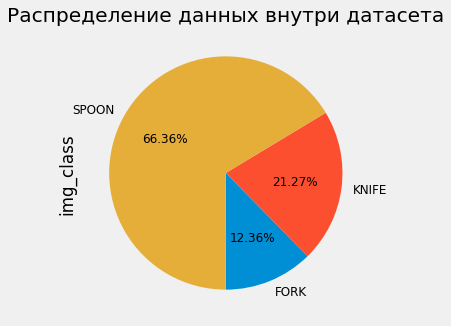

In [100]:
plt.figure(figsize=(5, 5))
df.groupby('img_label').count()['img_class'].plot(kind='pie', autopct='%1.2f%%', startangle=270, fontsize=12, title="Распределение данных внутри датасета")
plt.show()

### Цветовые гистограммы по трём каналам

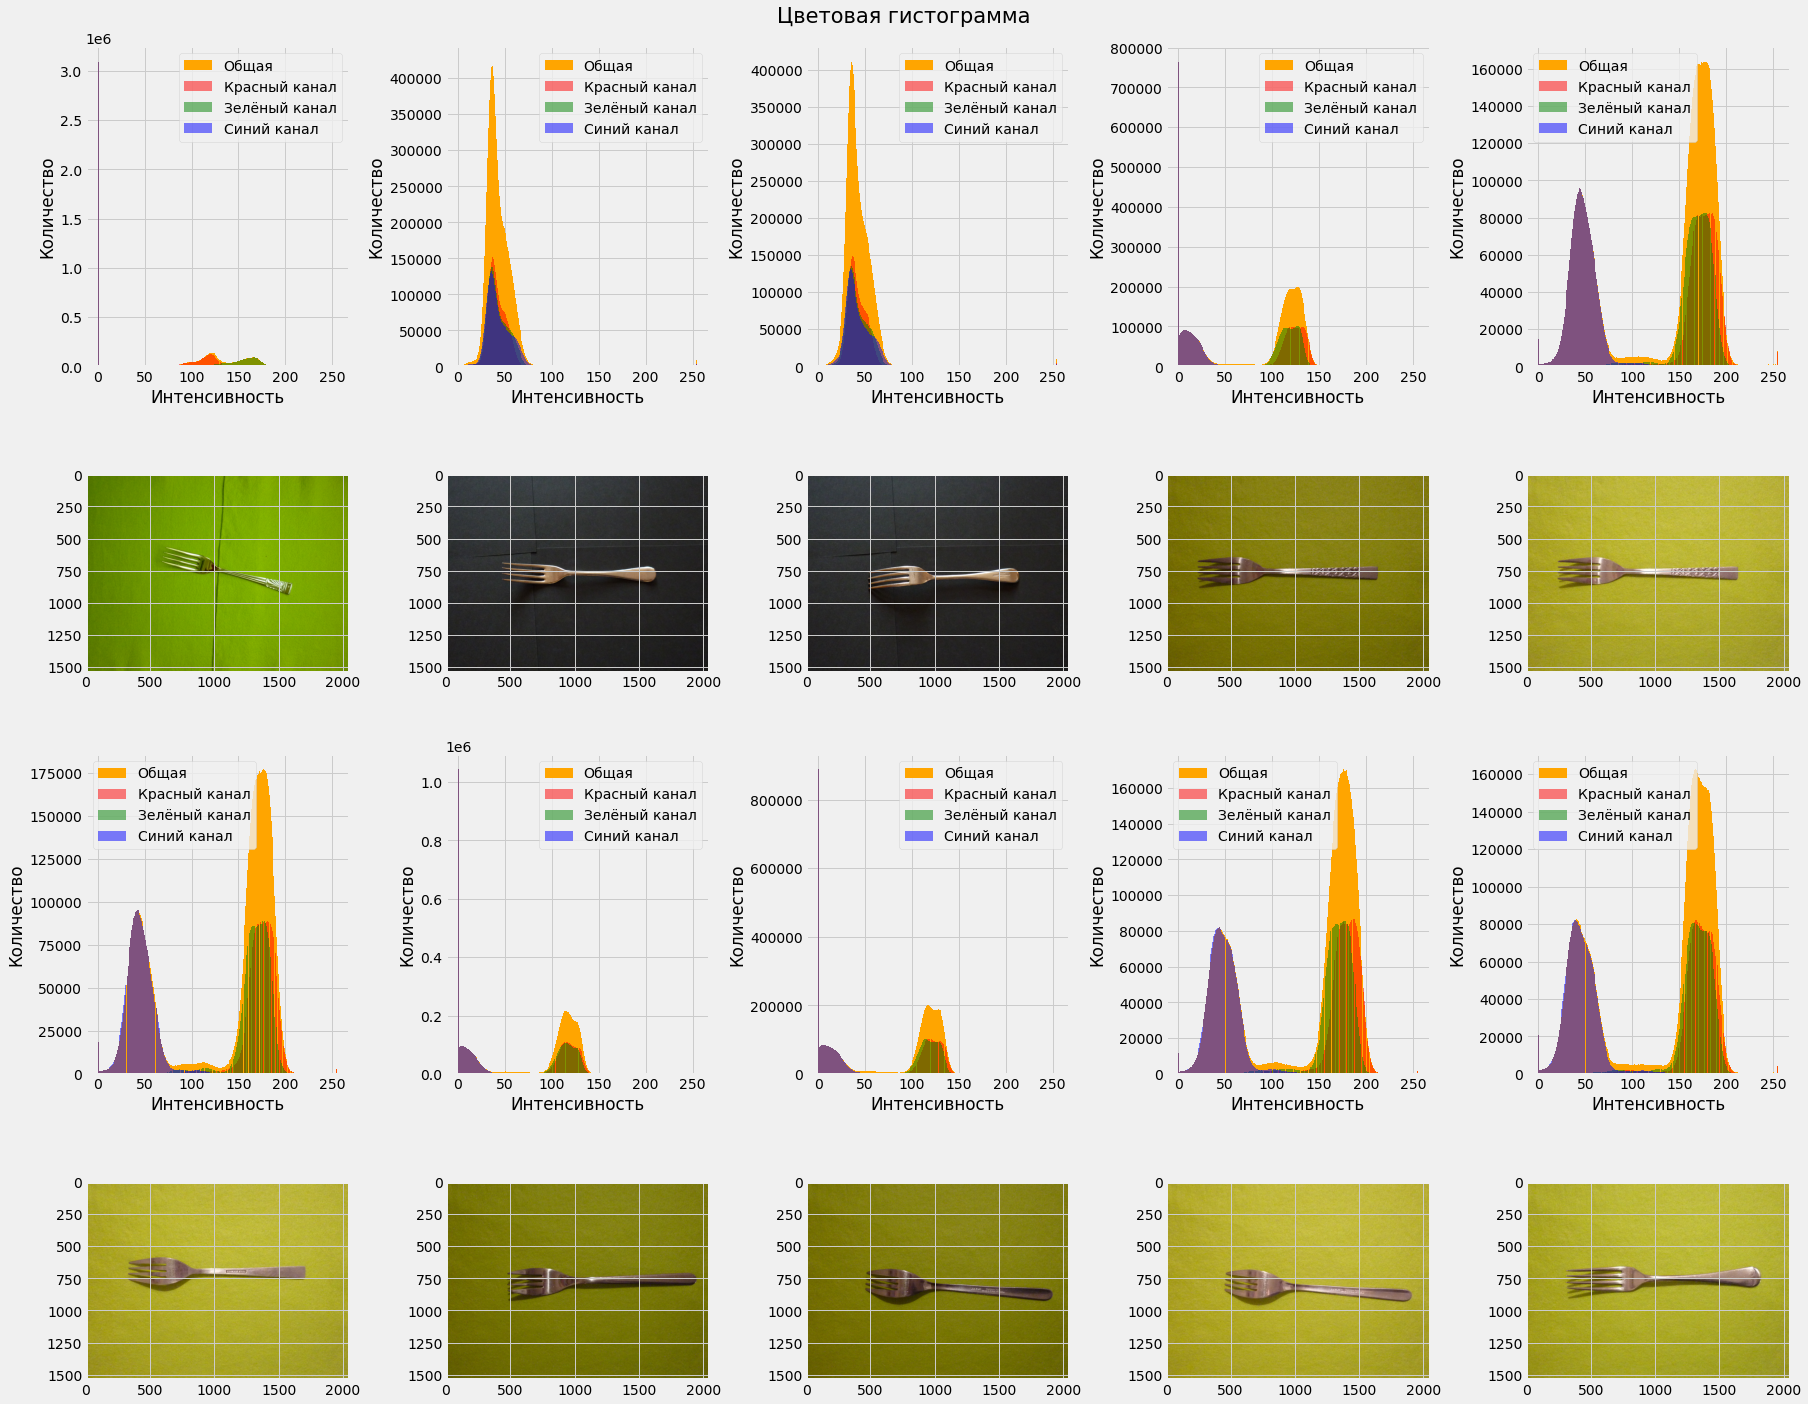

In [51]:
draw_pictures_with_hists(df[:10])

## Предобработка данных

### Добавление экземпляров

Функция изменения размера датасета до определенного количества экземпляров каждого класса 

In [54]:
def balance_data_size(train_generator, max_items=100, suf_dir=''):
    working_dir = os.path.join(os.path.relpath(os.path.join(
        train_generator.directory, "../")), f'Work_{suf_dir}')
    if os.path.isdir(working_dir):
        shutil.rmtree(working_dir)
    os.mkdir(working_dir)
    labels, counts = np.unique(train_generator.labels, return_counts=True)
    img_size = train_generator.target_size
    batch_size = train_generator.batch_size
    rotation = 45
    datagen = ImageDataGenerator(rotation_range=rotation,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.1,
                                 # zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode="constant",
                                 validation_split=0.2
                                 )
    subset = 'validation' if suf_dir == 'test' else 'training'
    for label in train_generator.class_indices.keys():
        items_count = counts[np.where(
            labels == train_generator.class_indices[label])[0][0]]
        start_items = max_items
        if items_count < max_items:
            os.mkdir(os.path.join(working_dir, label))
            datagen_new = datagen.flow_from_directory(train_generator.directory,
                                                      subset=subset,
                                                      target_size=(256, 256),
                                                      batch_size=1,
                                                      seed=SEED,
                                                      class_mode='categorical',
                                                      save_to_dir=os.path.join(
                                                          working_dir, label),
                                                      classes=[label],
                                                      save_prefix=f"new_{label}",
                                                      save_format="jpeg")

            for _ in range(max_items - items_count):
                next(datagen_new)
            start_items = items_count
            print(
                f"Добавлено {max_items - items_count} элеметов в класс {label}\n")
        else:
            print(f"Выбрано {max_items} элеметов из класса {label}\n")
        files = list(map(lambda x: x if label == x.split(
            '\\')[0] else '', train_generator.filenames))
        files = [x for x in files if x]

        for i in range(start_items):
            os.makedirs(os.path.dirname(os.path.join(
                working_dir, label+'\\')), exist_ok=True)
            shutil.copy(os.path.join(
                train_generator.directory, files[i]), os.path.join(working_dir, label))

    train_generator = ImageDataGenerator(rescale=1. / 255.).flow_from_directory(working_dir,
                                                                                                 target_size=(256, 256),
                                                                                                 batch_size=batch_size,
                                                                                                 shuffle=False,
                                                                                                 class_mode='categorical',
                                                                                                 color_mode='rgb')

    return train_generator, working_dir


Процедура добавления изменённых экземпляров

In [11]:
def add_data_transformed(image_path, classes_dict, max_add_items): 
    rotation = 30
    datagen = ImageDataGenerator(rotation_range=rotation, 
                                width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                shear_range=0.1, 
                                zoom_range=0.2, 
                                horizontal_flip=True, 
                                vertical_flip=True, 
                                fill_mode="nearest"
                                )
    for label in classes_dict.keys():
        datagen_new = datagen.flow_from_directory(image_path,
                                        batch_size=1,
                                        seed=SEED,
                                        class_mode='categorical',
                                        save_to_dir=image_path + label,
                                        classes=[label],
                                        save_prefix=f"added_{label}",
                                        save_format="jpeg")

        if max_add_items is None:
            max_add_items = len(datagen_new)*round((360/rotation))
        for _ in range(max_add_items):
            next(datagen_new)


Расширение датасета 

In [12]:
#add_data_transformed(IMAGE_PATH, classes_dict, 250)

### Обработка и разделение данных 

In [52]:
img_size = (128,128)
batch_size = 128
datagen = ImageDataGenerator(
    rescale=1. / 255., 
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2)
train_generator = datagen.flow_from_directory(IMAGE_PATH, 
                                    subset='training',
                                    target_size=img_size, 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
test_generator = datagen.flow_from_directory(IMAGE_PATH, 
                                    subset='validation',
                                    target_size=img_size, 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
classes_number = train_generator.num_classes

Found 441 images belonging to 3 classes.
Found 109 images belonging to 3 classes.


Балансировка количества экземпляров в каждом классе обучающей выборки

In [14]:
samples_per_classes = int(round(train_generator.samples/train_generator.num_classes+50, -2))
print(f"Количество экземляров на каждый класс: {samples_per_classes}")

Количество экземляров на каждый класс: 200


In [55]:
train_generator, working_dir = balance_data_size(train_generator, 2000, 'train')

Found 55 images belonging to 1 classes.
Добавлено 1945 элеметов в класс FORK

Found 94 images belonging to 1 classes.
Добавлено 1906 элеметов в класс KNIFE

Found 292 images belonging to 1 classes.
Добавлено 1708 элеметов в класс SPOON

Found 6000 images belonging to 3 classes.


In [56]:
test_generator, working_dir = balance_data_size(test_generator, 200, 'test')

Found 13 images belonging to 1 classes.
Добавлено 187 элеметов в класс FORK

Found 23 images belonging to 1 classes.
Добавлено 177 элеметов в класс KNIFE

Found 73 images belonging to 1 classes.
Добавлено 127 элеметов в класс SPOON

Found 600 images belonging to 3 classes.


Преобразование генераторов в плоские массивы

In [17]:
y_test = test_generator.classes
y_train = train_generator.classes

x_test = np.concatenate([test_generator.next()[0] for _ in range(test_generator.__len__())]).reshape(y_test.shape[0], -1)
x_train = np.concatenate([train_generator.next()[0] for _ in range(train_generator.__len__())]).reshape(y_train.shape[0], -1)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

Разделение на обучающую и валидационную выборки

In [101]:
train_df = pd.DataFrame(data={'path':train_generator.filepaths, 'label': list(map(lambda x: x.split('\\')[0], train_generator.filenames))})
train_df, valid_df=train_test_split(train_df, train_size=0.8, shuffle=True, random_state=SEED, stratify=train_df['label'])
train_generator_df =  ImageDataGenerator(rescale=1. / 255.).flow_from_dataframe(train_df,
                                              x_col='path',
                                              y_col='label',
                                              target_size=(256,256),
                                              class_mode='categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              color_mode='rgb')
valididation_generator_df =  ImageDataGenerator(rescale=1. / 255.).flow_from_dataframe(valid_df,
                                              x_col='path',
                                              y_col='label',
                                              target_size=(256,256),
                                              class_mode='categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              color_mode='rgb')

Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.


Пример изображения и его гистограммы после обработки

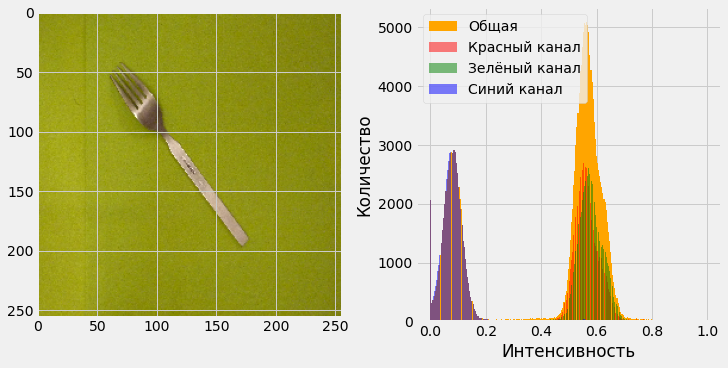

In [102]:
draw_image_with_hist(train_generator[0][0][0])

## Моделирование

Разбиение данных для кросс-валидации

In [18]:
kfold = RepeatedKFold(n_splits=5, n_repeats=1,  random_state=SEED)

### Понижение размерности

Projecting 196608-dimensional data to 2D


e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # Remove the CWD from sys.path while we load stuff.


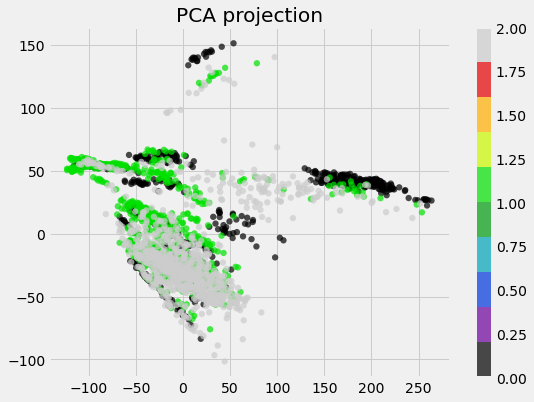

In [86]:
pca = decomposition.PCA(n_components=2)
x_reduced = pca.fit_transform(x_train_scaled)

print('Projecting %d-dimensional data to 2D' % x_train_scaled.shape[1])

plt.figure(figsize=(8, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_train,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection')
plt.show()


In [23]:
pca = decomposition.PCA().fit(x_train_scaled)

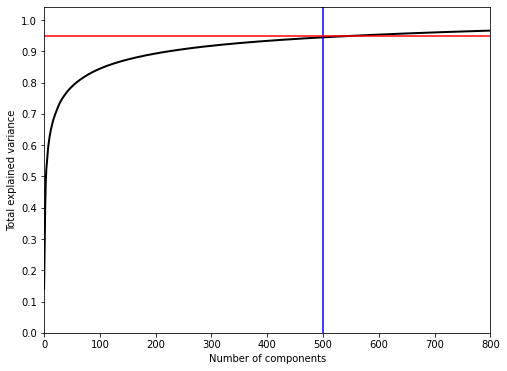

In [26]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 800)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(500, c='b')
plt.axhline(0.95, c='r')
plt.show()

In [19]:
pca = decomposition.PCA(0.95).fit(x_train_scaled)
x_train_reduced = pca.transform(x_train_scaled)
x_test_reduced = pca.transform(x_test_scaled)

### Функции для моделирования

Отрисовка матрицы неточностей

In [20]:
def draw_heat(y_test, y_pred):
    class_names = y_test
    fig, ax = plt.subplots(figsize=(10, 8)) 
    plt.title('Матрица неточностей')
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)
    sns.heatmap(pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred)),
        annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')


In [63]:
def print_report(y_test, y_pred, classes_dict):
    classes=list(classes_dict.keys())
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(metrics.confusion_matrix(y_test, y_pred ), annot=True, vmin=0, fmt='g', cmap='RdPu', cbar=True)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90)
    plt.yticks(np.arange(length)+.5, classes, rotation=0)
    plt.xlabel("Предсказанные значения")
    plt.ylabel("Действительные значения")
    plt.title("Матрица неточностей")
    plt.show()
    class_rep = classification_report(y_test, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", class_rep)

Отрисовка графика с ошибкой

In [22]:
def plot_with_err(x, data, **kwargs):
    data_mean, data_std = data.mean(axis=1), data.std(axis=1)
    lines = plt.plot(x, data_mean, '-', **kwargs)
    plt.fill_between(x, data_mean - data_std, data_mean + data_std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)


Отрисовка обучающих кривых

In [23]:
def pooled_variance(stds, n=5):
  return np.sqrt(sum((n-1)*(stds**2)) / len(stds)*(n-1))

def print_learning_curve(grid_result, parameters):
    df = pd.DataFrame(grid_result.cv_results_)
    results = ['mean_test_score',
              'mean_train_score',
              'std_test_score',
              'std_train_score']
    fig, axes = plt.subplots(1, len(parameters), figsize=(
        5*len(parameters), 7))
    axes[0].set_ylabel("Score")

    for i, (param_name, param_range) in enumerate(parameters.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': np.mean,
                  'mean_test_score': np.mean,
                  'std_train_score': pooled_variance,
                  'std_test_score': pooled_variance})
        axes[i].set_xlabel(param_name)
        if isinstance(parameters[param_name][0], str):
            x = np.arange(len(param_range))
            width = 0.35
            axes[i].bar(x-width/2,
                        grouped_df['mean_train_score'],
                        width,
                        yerr=[grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                              grouped_df['mean_train_score'] + grouped_df['std_train_score']],
                        color="red",
                        error_kw={'elinewidth': 1, 'capsize': 6},
                        label="Training score")
            axes[i].bar(x + width/2,
                        grouped_df['mean_test_score'],
                        width,
                        yerr=[grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                              grouped_df['mean_test_score'] + grouped_df['std_test_score']],
                        color="green",
                        alpha=0.6,
                        error_kw={'elinewidth': 1, 'capsize': 10},
                        label="Cross-validation score")
            axes[i].set_xticks(x)
            axes[i].set_xticklabels(param_range)
        else:
            #axes[i].set_ylim(0.0, 1.1)
            axes[i].plot(param_range,
                        grouped_df['mean_train_score'],
                        label="Training score",
                        color="red",
                        lw=2)
            axes[i].fill_between(param_range,
                                grouped_df['mean_train_score'] -
                                grouped_df['std_train_score'],
                                grouped_df['mean_train_score'] +
                                grouped_df['std_train_score'],
                                alpha=0.2,
                                color="red",
                                lw=2)
            axes[i].plot(param_range,
                        grouped_df['mean_test_score'],
                        label="Cross-validation score",
                        color="green",
                        lw=2)
            axes[i].fill_between(param_range,
                                grouped_df['mean_test_score'] -
                                grouped_df['std_test_score'],
                                grouped_df['mean_test_score'] +
                                grouped_df['std_test_score'],
                                alpha=0.2,
                                color="green",
                                lw=2)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Learning curves', fontsize=25)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=15)

    fig.subplots_adjust(bottom=0.25, top=0.85)
    plt.show()


Функция отчёта grid search

In [24]:
def print_grid_report(grid_result):
    print(f"Best: {grid_result.best_score_:.4f} using { grid_result.best_params_}")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f"{mean:.4f} ({stdev:.4f}) with: {param}") 

### Обучение без учителя

In [55]:
kmeans = KMeans(n_clusters=3, random_state=SEED).fit(x_train_reduced)
kmeans_pred = kmeans.predict(x_test_reduced)

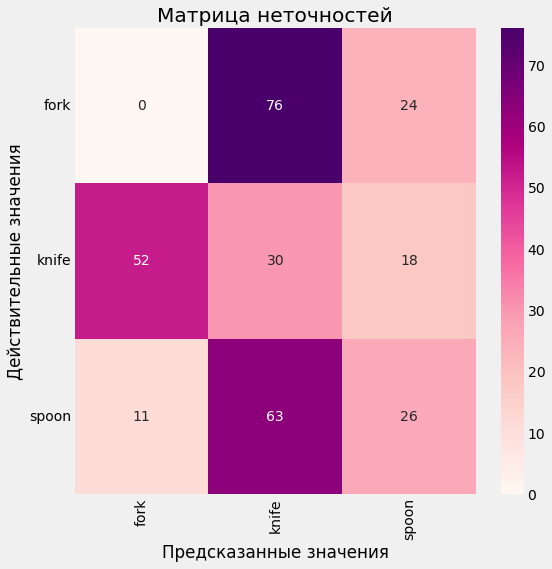

Classification Report:
----------------------
               precision    recall  f1-score   support

        fork       0.00      0.00      0.00       100
       knife       0.18      0.30      0.22       100
       spoon       0.38      0.26      0.31       100

    accuracy                           0.19       300
   macro avg       0.19      0.19      0.18       300
weighted avg       0.19      0.19      0.18       300



In [56]:
print_report(y_test, kmeans_pred, classes_dict)

In [57]:
kmeans1 = KMeans(n_clusters=3, random_state=SEED).fit(x_train_scaled)
kmeans_pred1 = kmeans1.predict(x_test_scaled)

KeyboardInterrupt: 

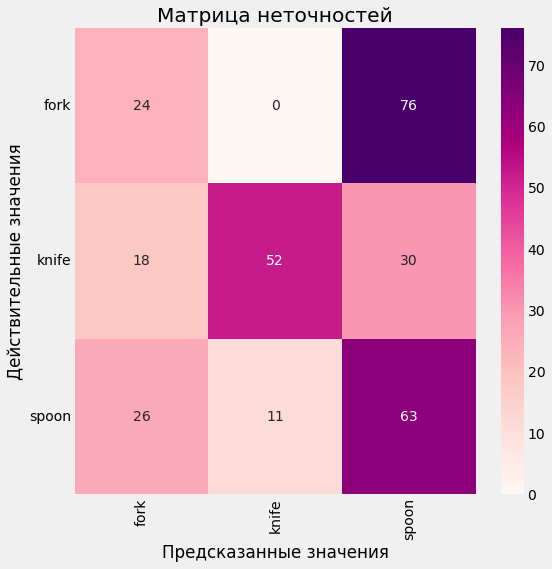

Classification Report:
----------------------
               precision    recall  f1-score   support

        fork       0.35      0.24      0.29       100
       knife       0.83      0.52      0.64       100
       spoon       0.37      0.63      0.47       100

    accuracy                           0.46       300
   macro avg       0.52      0.46      0.46       300
weighted avg       0.52      0.46      0.46       300



In [30]:
print_report(y_test, kmeans_pred1, classes_dict)

### Логистическая регрессия 

In [61]:
params_logreg = {'solver': ['lbfgs', 'sag', 'saga'],'C':np.logspace(-3,3,7)}
logreg = LogisticRegression()
grid_search_logreg = GridSearchCV(estimator = logreg,  
                           param_grid = params_logreg,
                           scoring = 'f1_weighted',
                           cv = kfold,
                           return_train_score=True,
                           verbose=0)

grid_result_logreg = grid_search_logreg.fit(x_train_reduced, y_train)

In [62]:
print_grid_report(grid_search_logreg)

Best: 0.4292 using {'C': 0.001, 'solver': 'sag'}
0.4268 (0.0069) with: {'C': 0.001, 'solver': 'lbfgs'}
0.4292 (0.0075) with: {'C': 0.001, 'solver': 'sag'}
0.4272 (0.0063) with: {'C': 0.001, 'solver': 'saga'}
0.4167 (0.0083) with: {'C': 0.01, 'solver': 'lbfgs'}
0.4162 (0.0084) with: {'C': 0.01, 'solver': 'sag'}
0.4171 (0.0058) with: {'C': 0.01, 'solver': 'saga'}
0.4174 (0.0028) with: {'C': 0.1, 'solver': 'lbfgs'}
0.4186 (0.0051) with: {'C': 0.1, 'solver': 'sag'}
0.4149 (0.0070) with: {'C': 0.1, 'solver': 'saga'}
0.4164 (0.0054) with: {'C': 1.0, 'solver': 'lbfgs'}
0.4177 (0.0046) with: {'C': 1.0, 'solver': 'sag'}
0.4146 (0.0070) with: {'C': 1.0, 'solver': 'saga'}
0.4151 (0.0047) with: {'C': 10.0, 'solver': 'lbfgs'}
0.4170 (0.0042) with: {'C': 10.0, 'solver': 'sag'}
0.4149 (0.0078) with: {'C': 10.0, 'solver': 'saga'}
0.4180 (0.0045) with: {'C': 100.0, 'solver': 'lbfgs'}
0.4180 (0.0049) with: {'C': 100.0, 'solver': 'sag'}
0.4150 (0.0069) with: {'C': 100.0, 'solver': 'saga'}
0.4170 (0.0047)

In [63]:
y_pred_logreg = grid_result_logreg.predict(x_test_reduced)

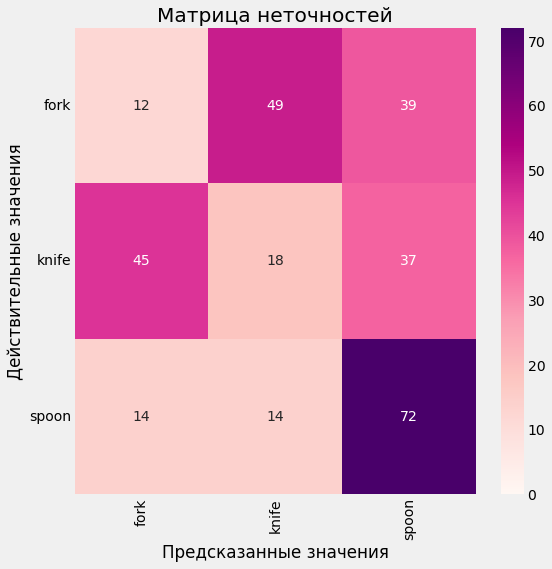

Classification Report:
----------------------
               precision    recall  f1-score   support

        fork       0.17      0.12      0.14       100
       knife       0.22      0.18      0.20       100
       spoon       0.49      0.72      0.58       100

    accuracy                           0.34       300
   macro avg       0.29      0.34      0.31       300
weighted avg       0.29      0.34      0.31       300



In [64]:
print_report(y_test, y_pred_logreg, classes_dict)

Обучающие кривые

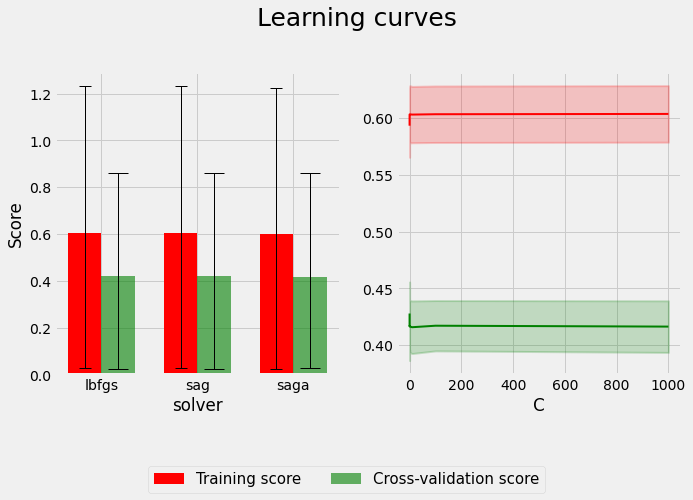

In [65]:
print_learning_curve(grid_result_logreg, params_logreg)

### Метод опорных векторов 

In [66]:
params_svc = {'gamma': [0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'], 'C':[1,10,100,1000]}
svc = svm.SVC()
grid_search_svc = GridSearchCV(estimator = svc,  
                           param_grid = params_svc,
                           scoring = 'f1_weighted',
                           cv = kfold,
                           return_train_score=True,
                           verbose=0)

grid_result_svc = grid_search_svc.fit(x_train_reduced, y_train)

In [67]:
print_grid_report(grid_result_svc)

Best: 0.5002 using {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.2413 (0.0066) with: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.5002 (0.0149) with: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.3357 (0.0273) with: {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.4280 (0.0207) with: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.5002 (0.0149) with: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.3086 (0.0148) with: {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.2502 (0.0095) with: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.5002 (0.0149) with: {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}
0.3314 (0.0257) with: {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.4418 (0.0161) with: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.5002 (0.0149) with: {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}
0.3077 (0.0153) with: {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.2502 (0.0095) with: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.5002 (0.0149) with: {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}
0.3311 (0.0253) with

In [69]:
y_pred_svc = grid_result_svc.predict(x_test_reduced)

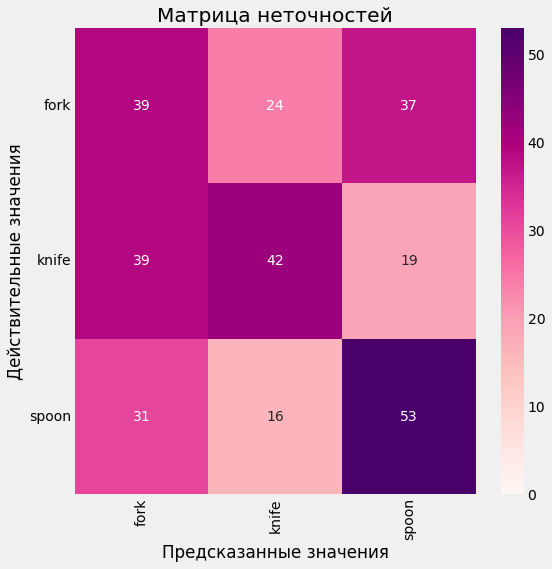

Classification Report:
----------------------
               precision    recall  f1-score   support

        fork       0.36      0.39      0.37       100
       knife       0.51      0.42      0.46       100
       spoon       0.49      0.53      0.51       100

    accuracy                           0.45       300
   macro avg       0.45      0.45      0.45       300
weighted avg       0.45      0.45      0.45       300



In [70]:
print_report(y_test, y_pred_svc, classes_dict)

Обучающие кривые

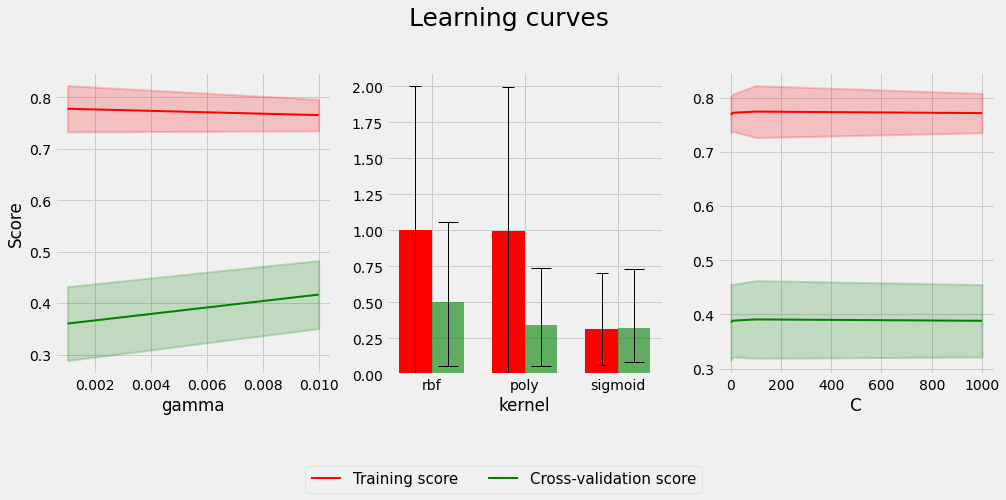

In [71]:
print_learning_curve(grid_result_svc, params_svc)

### Метод k ближайших соседей 

In [79]:
params_kneighbors = {'n_neighbors': list(range(1, round(x_train_reduced.shape[0]**(1/2)), 4)), 'weights': ['uniform', 'distance']}
kneighbors = KNeighborsClassifier(n_neighbors=5)
grid_search_kneighbors = GridSearchCV(estimator = kneighbors,  
                           param_grid = params_kneighbors,
                           scoring = 'f1_weighted',
                           cv = kfold,
                           return_train_score=True,
                           verbose=0)

grid_result_kneighbors = grid_search_kneighbors.fit(x_train_reduced, y_train)

In [80]:
print_grid_report(grid_result_kneighbors)

Best: 0.4877 using {'n_neighbors': 9, 'weights': 'distance'}
0.4794 (0.0149) with: {'n_neighbors': 1, 'weights': 'uniform'}
0.4794 (0.0149) with: {'n_neighbors': 1, 'weights': 'distance'}
0.4641 (0.0264) with: {'n_neighbors': 5, 'weights': 'uniform'}
0.4806 (0.0285) with: {'n_neighbors': 5, 'weights': 'distance'}
0.4766 (0.0180) with: {'n_neighbors': 9, 'weights': 'uniform'}
0.4877 (0.0166) with: {'n_neighbors': 9, 'weights': 'distance'}
0.4810 (0.0206) with: {'n_neighbors': 13, 'weights': 'uniform'}
0.4846 (0.0227) with: {'n_neighbors': 13, 'weights': 'distance'}
0.4758 (0.0200) with: {'n_neighbors': 17, 'weights': 'uniform'}
0.4775 (0.0224) with: {'n_neighbors': 17, 'weights': 'distance'}
0.4731 (0.0205) with: {'n_neighbors': 21, 'weights': 'uniform'}
0.4727 (0.0230) with: {'n_neighbors': 21, 'weights': 'distance'}
0.4756 (0.0206) with: {'n_neighbors': 25, 'weights': 'uniform'}
0.4776 (0.0270) with: {'n_neighbors': 25, 'weights': 'distance'}
0.4763 (0.0232) with: {'n_neighbors': 29, 

In [81]:
y_pred_kneighbors = grid_result_kneighbors.predict(x_test_reduced)

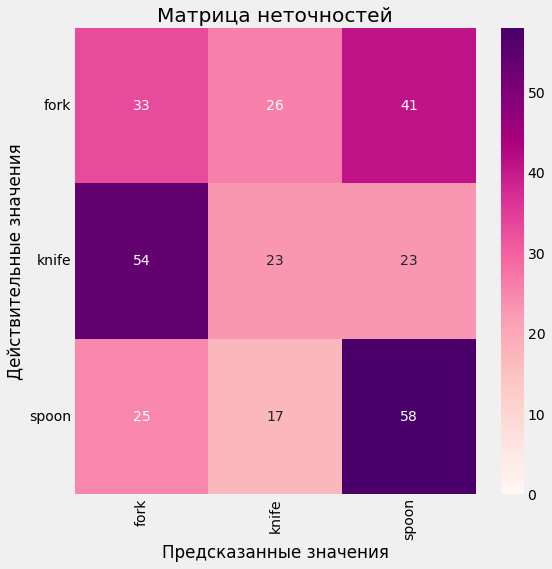

Classification Report:
----------------------
               precision    recall  f1-score   support

        fork       0.29      0.33      0.31       100
       knife       0.35      0.23      0.28       100
       spoon       0.48      0.58      0.52       100

    accuracy                           0.38       300
   macro avg       0.37      0.38      0.37       300
weighted avg       0.37      0.38      0.37       300



In [82]:
print_report(y_test, y_pred_kneighbors, classes_dict)

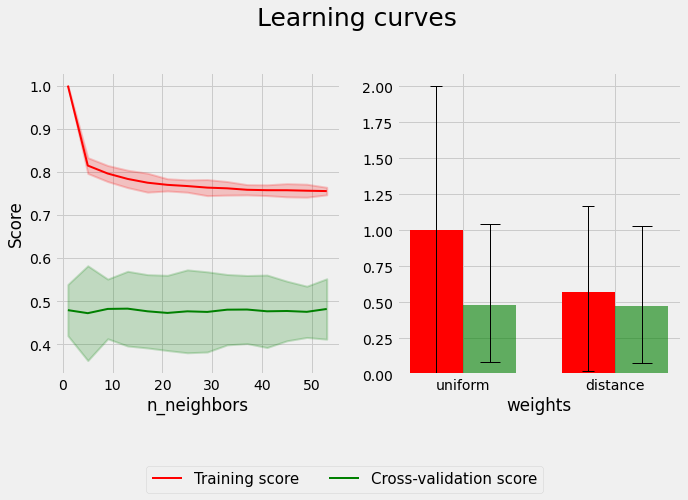

In [83]:
print_learning_curve(grid_result_kneighbors, params_kneighbors)

### Свёрточная нейросеть

#### Grid search

In [ ]:
def create_model(neurons):
    model = Sequential()
    model.add(Conv2D(neurons, (3, 3),
              input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))  # new 933
    model.add(MaxPooling2D(pool_size=(2, 2)))  # new
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(8, kernel_constraint=maxnorm(3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(classes_number))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
model = KerasClassifier(model=create_model, neurons=2, verbose=0)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [5, 10, 20, 25]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [2, 4, 8, 16, 32, 64, 128]
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid = dict(neurons=neurons)
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(x_train_scaled, y_train, epochs=40, batch_size=40)

print(f"Best: {grid_result.best_score_} using { grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}") 

Best: 0.155556 using {'neurons': 8}
0.096296 (0.136184) with: {'neurons': 2}
0.074074 (0.104757) with: {'neurons': 4}
0.155556 (0.110368) with: {'neurons': 8}
0.081481 (0.073330) with: {'neurons': 16}
0.074074 (0.104757) with: {'neurons': 32}
0.111111 (0.079089) with: {'neurons': 64}
0.074074 (0.104757) with: {'neurons': 128}


#### Модель

In [103]:
epochs=20
batch_size=5
model = Sequential()
model.add(Conv2D(4, (3, 3),input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))  # new 933
#model.add(MaxPooling2D(pool_size=(2, 2)))  # new
#model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16, kernel_constraint=maxnorm(3), activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dense(classes_number))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [104]:
history = model.fit(train_generator_df, validation_data=valididation_generator_df, epochs=epochs, batch_size=batch_size)

Epoch 1/20
38/38 [==============================] - 124s 3s/step - loss: 1.7660 - accuracy: 0.4335 - val_loss: 1.5031 - val_accuracy: 0.4242
Epoch 2/20
38/38 [==============================] - 119s 3s/step - loss: 1.3085 - accuracy: 0.5188 - val_loss: 1.4374 - val_accuracy: 0.3333
Epoch 3/20
38/38 [==============================] - 120s 3s/step - loss: 1.1500 - accuracy: 0.5594 - val_loss: 1.4341 - val_accuracy: 0.3333
Epoch 4/20
38/38 [==============================] - 119s 3s/step - loss: 1.0696 - accuracy: 0.5854 - val_loss: 1.4878 - val_accuracy: 0.3333
Epoch 5/20
38/38 [==============================] - 119s 3s/step - loss: 0.9912 - accuracy: 0.6394 - val_loss: 1.4647 - val_accuracy: 0.3333
Epoch 6/20
38/38 [==============================] - 118s 3s/step - loss: 0.9843 - accuracy: 0.6569 - val_loss: 1.5109 - val_accuracy: 0.3333
Epoch 7/20
38/38 [==============================] - 119s 3s/step - loss: 0.9702 - accuracy: 0.6806 - val_loss: 1.4592 - val_accuracy: 0.3333
Epoch 8/20
38

In [105]:
prediction = model.predict(test_generator)

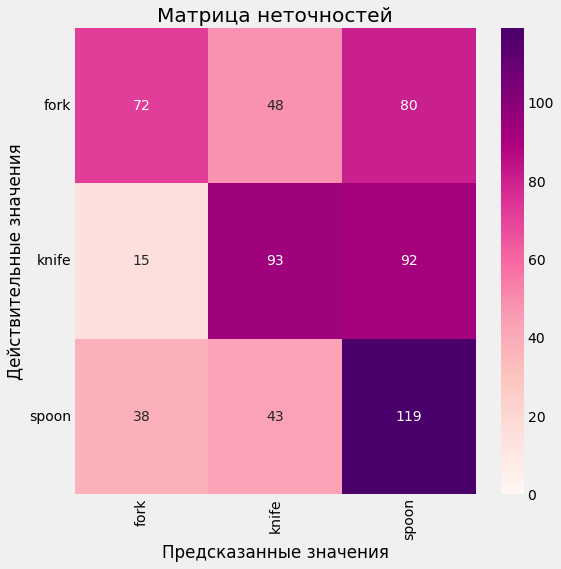

Classification Report:
----------------------
               precision    recall  f1-score   support

        fork       0.58      0.36      0.44       200
       knife       0.51      0.47      0.48       200
       spoon       0.41      0.59      0.48       200

    accuracy                           0.47       600
   macro avg       0.50      0.47      0.47       600
weighted avg       0.50      0.47      0.47       600



In [106]:
print_report(test_generator.classes, prediction.argmax(axis=1), classes_dict)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
x_test = np.concatenate([test_generator.next()[0] for _ in range(test_generator.__len__())])
x_train = np.concatenate([train_generator.next()[0] for _ in range(train_generator.__len__())])

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
scoring = ['accuracy', 'f1_weighted']
estimator= KerasClassifier(model=model, epochs=epochs, batch_size=batch_size, verbose=0)
result_nn = cross_validate(estimator, x_train, y_train, cv=kfold, return_estimator=True, scoring=scoring)  

INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp4f04hjr8\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmpfwzwyt_f\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp7l6uppcy\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp7bo2m29q\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp_3wh227_\assets


In [ ]:
y_pred_nn = result_nn.predict(x_test_scaled)

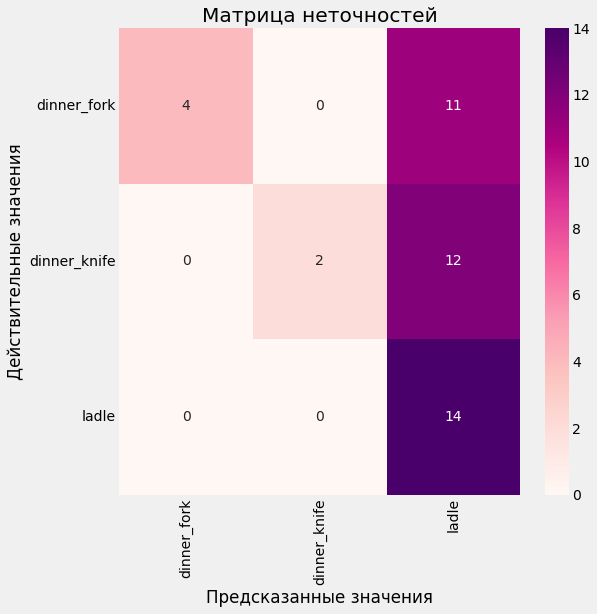

Classification Report:
----------------------
               precision    recall  f1-score   support

 dinner_fork       1.00      0.27      0.42        15
dinner_knife       1.00      0.14      0.25        14
       ladle       0.38      1.00      0.55        14

    accuracy                           0.47        43
   macro avg       0.79      0.47      0.41        43
weighted avg       0.80      0.47      0.41        43



In [182]:
print_report(test_generator.classes, y_pred_nn, classes_dict)

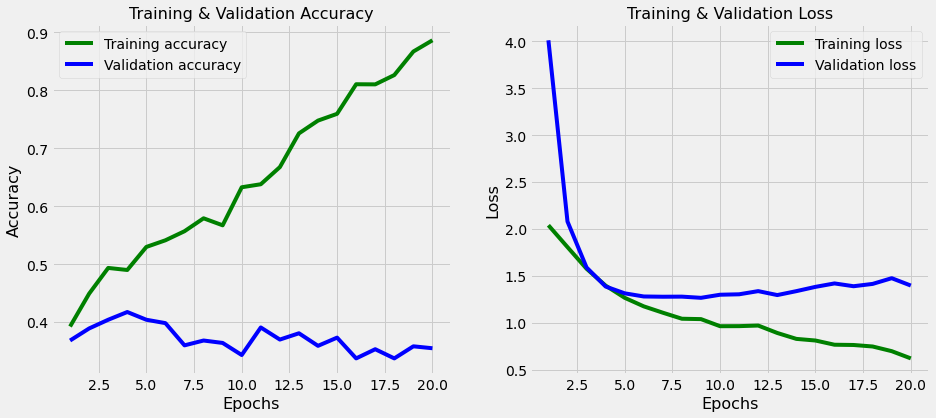

In [80]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(epochs, accuracy, 'g', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

ax[1].plot(epochs, loss_values, 'g', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()
plt.show()